### Plotting GP uncertainty results & London census demographic data

In [182]:
import geopandas as gpd
import matplotlib.pyplot as plt
import folium
import datetime
import numpy as np
from shapely.geometry import Point, Polygon
import pandas as pd
import pickle

In [183]:
london_wards = gpd.read_file("../data-collection/statistical-gis-boundaries-london/ESRI/London_Ward.shp")
london_wards = london_wards.to_crs("EPSG:4326")
london_wards.head()

,NAME,GSS_CODE,HECTARES,NONLD_AREA,LB_GSS_CD,BOROUGH,POLY_ID,geometry
0,Chessington South,E05000405,755.173,0.0,E09000021,Kingston upon Thames,50840,"POLYGON ((-0.33068 51.32901, -0.33059 51.32909..."
1,Tolworth and Hook Rise,E05000414,259.464,0.0,E09000021,Kingston upon Thames,117160,"POLYGON ((-0.30846 51.37586, -0.30834 51.37606..."
2,Berrylands,E05000401,145.390,0.0,E09000021,Kingston upon Thames,50449,"POLYGON ((-0.30385 51.39249, -0.30375 51.39252..."
3,Alexandra,E05000400,268.506,0.0,E09000021,Kingston upon Thames,50456,"POLYGON ((-0.26990 51.38845, -0.26975 51.38838..."
4,Beverley,E05000402,187.821,0.0,E09000021,Kingston upon Thames,117161,"POLYGON ((-0.24662 51.39921, -0.24672 51.39921..."


In [184]:
economic_inactivity_df = pd.read_csv('../data-collection/datashine_QS601EW0011_Ward.csv',index_col=False)
economic_inactivity_df = economic_inactivity_df.rename(columns={'Ward Name': 'NAME', 'Ward Percentage': 'Economic Inactivity %'})
economic_inactivity_df.head()

,Ward Code,NAME,LA Name,Region Name,QS601EW0011,QS601EW0001 (base),Economic Inactivity %
0,E05000001,Aldersgate,City of London,London,257,1221,21.05
1,E05000005,Bishopsgate,City of London,NaN,34,215,15.81
2,E05000352,Feltham West,Hounslow,London,2833,11266,25.15
3,E05000353,Hanworth,Hounslow,London,2579,8586,30.04
4,E05000354,Hanworth Park,Hounslow,London,2246,8392,26.76


In [185]:
# merge london ward geodf with census ward data
london_wards = pd.merge(london_wards, economic_inactivity_df, how='inner', on=['NAME'])
london_wards.head()

,NAME,GSS_CODE,HECTARES,NONLD_AREA,LB_GSS_CD,BOROUGH,POLY_ID,geometry,Ward Code,LA Name,Region Name,QS601EW0011,QS601EW0001 (base),Economic Inactivity %
0,Chessington South,E05000405,755.173,0.0,E09000021,Kingston upon Thames,50840,"POLYGON ((-0.33068 51.32901, -0.33059 51.32909...",E05000405,Kingston upon Thames,London,1746,7467,23.38
1,Tolworth and Hook Rise,E05000414,259.464,0.0,E09000021,Kingston upon Thames,117160,"POLYGON ((-0.30846 51.37586, -0.30834 51.37606...",E05000414,Kingston upon Thames,London,1769,7216,24.51
2,Berrylands,E05000401,145.390,0.0,E09000021,Kingston upon Thames,50449,"POLYGON ((-0.30385 51.39249, -0.30375 51.39252...",E05000401,Kingston upon Thames,London,1870,7106,26.32
3,Alexandra,E05000400,268.506,0.0,E09000021,Kingston upon Thames,50456,"POLYGON ((-0.26990 51.38845, -0.26975 51.38838...",E05000400,Kingston upon Thames,London,1807,6674,27.08
4,Alexandra,E05000400,268.506,0.0,E09000021,Kingston upon Thames,50456,"POLYGON ((-0.26990 51.38845, -0.26975 51.38838...",E05000266,Haringey,London,2018,8788,22.96


<AxesSubplot:>

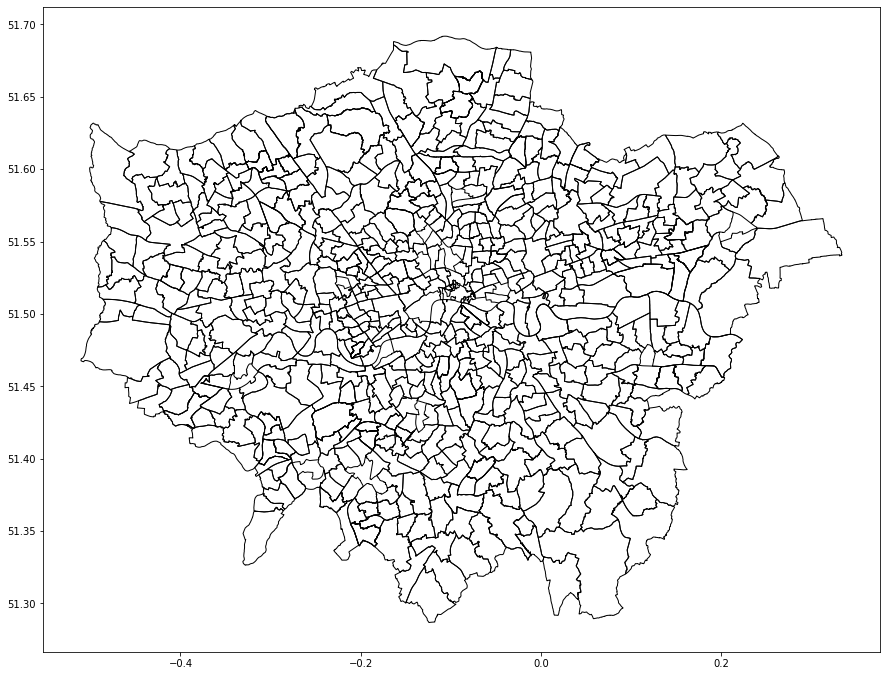

In [109]:
fig, ax = plt.subplots(figsize=(15,15))
ax.set_facecolor('white')
london_wards.plot(ax=ax, color="None")

In [176]:
def sample_ward_points(n_samples=5, iter=5, plot=False):
    # creates london ward geopandas df that contains shapely polygons
    london_wards = gpd.read_file("../data-collection/statistical-gis-boundaries-london/ESRI/London_Ward.shp")
    london_wards = london_wards.to_crs("EPSG:4326").explode(index_parts=False)
    
    # keep track of samples
    
    sample_sites = {'ward': [], 'code': [], 'latitude': [], 'longitude': []}
    
    for index, row in london_wards.iterrows():

        ward = row.geometry
        ward_name = row.NAME

        if ward_name not in sample_sites['ward']:
            # get ward boundaries, add noise to make bounding box more constraint
            noise = 0.001
            min_longitude = ward.bounds[0] + noise
            min_latitude = ward.bounds[1] + noise
            max_longitude = ward.bounds[2] - noise
            max_latitude = ward.bounds[3] - noise

            ## produce randomly distributed values of latitude and longitude coordinates within ward max and min boundaries
            latitudes = np.random.rand(int(iter**0.5)) * (max_latitude - min_latitude) + min_latitude
            longitudes =  np.random.rand(int(iter**0.5)) * (max_longitude - min_longitude) + min_longitude

            # latitudes = np.random(min_latitude, max_latitude, int(iter**0.5))
            # longitudes =  np.linspace(min_longitude, max_longitude, int(iter**0.5))

            curr_ward_num_samples = 0
            all_sample_codes = []
            all_sample_lats = []
            all_sample_longs = []
            for i in range(int(iter**0.5)):
                for j in range(int(iter**0.5)):
                    num_decimal_places = 13
                    float_long = round(float(longitudes[i]), num_decimal_places)
                    float_lat = round(float(latitudes[j]), num_decimal_places)
                    
                    ## creates Point instance of coordinate and a bounding polygon that contains the point
                    coord = Point(float_long, float_lat)
                    p_range = [-0.000001, 0.0, 0.000001]
                    poly_point = Polygon([(coord.x + lam_lat, coord.y + lam_lon) for lam_lat in p_range for lam_lon in p_range])
                    
                    ## finds whether the bounding coordinate polygon intersects with the burough boundaries
                    if ward.intersects(poly_point): 
                        all_sample_codes.append(curr_ward_num_samples)                
                        all_sample_lats.append(latitudes[j])
                        all_sample_longs.append(longitudes[i])
                        curr_ward_num_samples += 1
            
            # get random n samples across entire ward
            rand_indices = np.linspace(0, curr_ward_num_samples - 1, num=n_samples).astype('int')
            for ind in rand_indices:
                sample_sites['ward'].append(ward_name)
                sample_sites['code'].append(all_sample_codes[ind])
                sample_sites['latitude'].append(all_sample_lats[ind])
                sample_sites['longitude'].append(all_sample_longs[ind])

        
        
    sample_sites_df = pd.DataFrame(sample_sites)
    
    ## plot london boundaries and selected locations of set U
    if plot:
        london_wards.plot()
        plt.show()

        sample_sites_df.plot(x="longitude", y="latitude", title=f"Ward Sample Sites, n={n_samples}", kind="scatter")
        plt.show()

    return sample_sites_df

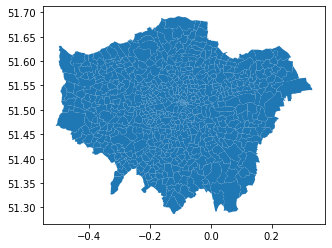

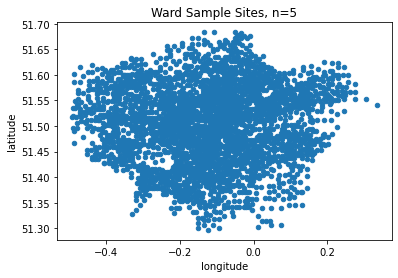

In [177]:
sample_sites_df = sample_ward_points(n_samples=5, iter=25, plot=True)

In [186]:
grouped_samples_ward = sample_sites_df.groupby('ward').count()
grouped_samples_ward['code'].unique() # there should be exactly n_samples as the only unique value

array([5])

In [179]:
sample_sites_geodf = gpd.GeoDataFrame(
        sample_sites_df, geometry=gpd.points_from_xy(sample_sites_df.longitude, sample_sites_df.latitude))

In [187]:
sample_sites_geodf

,ward,code,latitude,longitude,geometry
0,Chessington South,0,51.327320,-0.329756,POINT (-0.32976 51.32732)
1,Chessington South,1,51.336828,-0.318843,POINT (-0.31884 51.33683)
2,Chessington South,3,51.355844,-0.318843,POINT (-0.31884 51.35584)
3,Chessington South,5,51.346336,-0.307929,POINT (-0.30793 51.34634)
4,Chessington South,7,51.355844,-0.297015,POINT (-0.29701 51.35584)
...,...,...,...,...,...
3130,Candlewick,0,51.511177,-0.087673,POINT (-0.08767 51.51118)
3131,Candlewick,6,51.511304,-0.087294,POINT (-0.08729 51.51130)
3132,Candlewick,12,51.511431,-0.086916,POINT (-0.08692 51.51143)
3133,Candlewick,18,51.511558,-0.086538,POINT (-0.08654 51.51156)


In [181]:
'''
Save map to interactive html map file using the Folium library.
'''
# create folium map of buroughs
london_center = [51.507602, -0.127816]
m = folium.Map(location=london_center, zoom_start=10, tiles='cartodb positron')

london_wards.explore(
    m=m,
    column="Economic Inactivity %", # make choropleth based on "BoroName" column
    color="grey",
    tooltip="NAME", # show "BoroName" value in tooltip (on hover)
    popup=True, # show all values in popup (on click)
    tiles="CartoDB positron", # use "CartoDB positron" tiles
    cmap="YlGnBu", # use "Set1" matplotlib colormap
    legend=True, # show legend on the map
    # legend_name='Economic Inactivity %',
    style_kwds=dict(color="black", weight=3, opacity=0.5) # use black outline
)

# add sample points to geodataframe of data to folium map
sample_sites_geodf.explore(
    m=m, # pass the map object
    marker_kwds=dict(radius=3, fill=True), # make marker radius 10px with fill
    # column='QS601EW0011', # make choropleth based on {pollutant} column
    popup=True,
    tooltip=["ward", 'longitude', 'latitude'], # show "name" column in the tooltip
    tooltip_kwds=dict(labels=True), # do not show column label in the tooltip
    name='Ward Sample Sites', # name of the layer in the map
    cmap= "OrRd",
)

folium.LayerControl().add_to(m)  # use folium to add layer control

# Save map to mapping directory
# as HTML file
map_name = "wardSamples_economicInactivity_map"
print("Saving map to: ", map_name)
m.save('../gp-models/GPR_figures/' + map_name + ".html")

Saving map to:  wardSamples_economicInactivity_map


In [ ]:
def load_model(filename):
    path = f"../gp-models/GPR-models/{filename}/{filename}"
    model = pickle.load(open(f"{path}_model.sav", 'rb'))
    df = pickle.load(open(f"{path}_df.sav", 'rb'))
    train_df = pickle.load(open(f"{path}_train_df.sav", 'rb'))
    test_df = pickle.load(open(f"{path}_test_df.sav", 'rb'))
    scalers = pickle.load(open(f"{path}_scalers.sav", 'rb'))
    
    return model, df, train_df, test_df, scalers

In [ ]:
# get average uncertainty value across wards from GP model
model_name = ""
model, df, train_df, test_df, scalers = load_model(model_name)

In [ ]:
for ward in sample_sites_geodf.ward.unique():
    ward_sample_lats = sample_sites_geodf.loc[sample_sites_geodf.ward == ward].latitude
    ward_sample_longs = sample_sites_geodf.loc[sample_sites_geodf.ward == ward].longitude
    